In [1]:
from Softs.Spanve_beta import *
from sklearn.metrics import adjusted_rand_score as ari
import scanpy as sc
import pandas as pd
target_sample_id = '151672'

adata= sc.read_h5ad(f'./recode/IMPUTEDLIBD/data/{target_sample_id}.h5ad')
adata = adata_preprocess(adata)
sc.pp.pca(adata)

label_BS = pd.read_csv(f'./recode/IMPUTEDLIBD/BS/{target_sample_id}_BS.out.csv',index_col=0)
label_BS['cell_ranger'] = pd.read_csv(f'./recode/IMPUTEDLIBD/BS/topK_{target_sample_id}.csv',index_col=0).iloc[:,0].values

cluster = AutoCluster()

In [2]:
label_KM = pd.DataFrame(
    {
        'spanve_impute': pd.Series(cluster.fit_predict(X=adata.obsm['spanve-k.imputated.pca']),index=adata.obs_names),
        'cell_ranger':  pd.Series(cluster.fit_predict(X=adata.obsm['cell_ranger.pca']),index=adata.obs_names),
        'base': pd.Series(cluster.fit_predict(X=adata.obsm['X_pca']),index=adata.obs_names),
    }
)

In [12]:
from sklearn.preprocessing import LabelEncoder
def plot_spatial(value,anndata,ax=None,s=4,add_text=''):
    if ax is None:
        fig,ax = plt.subplots()
    if value.dtype=='object':
        value = LabelEncoder().fit_transform(value)
    spatial_info = anndata.obsm['spatial']
    assert spatial_info.shape[0]==value.shape[0]
    ax.scatter(
        spatial_info[:,0],
        spatial_info[:,1],
        c=value,
        cmap='viridis',
        s=s,
        )
    ax.set_xticks([])
    ax.set_yticks([])
    if add_text:
        ax.text(
            s = add_text,
            x = 0.62,
            y = 0.02,
            transform=ax.transAxes,
            size=10,
        )
    return ax

In [4]:
label_KM.columns, label_BS.columns

(Index(['spanve_impute', 'cell_ranger', 'base'], dtype='object'),
 Index(['spanve_i', 'base', 'cell_ranger'], dtype='object'))

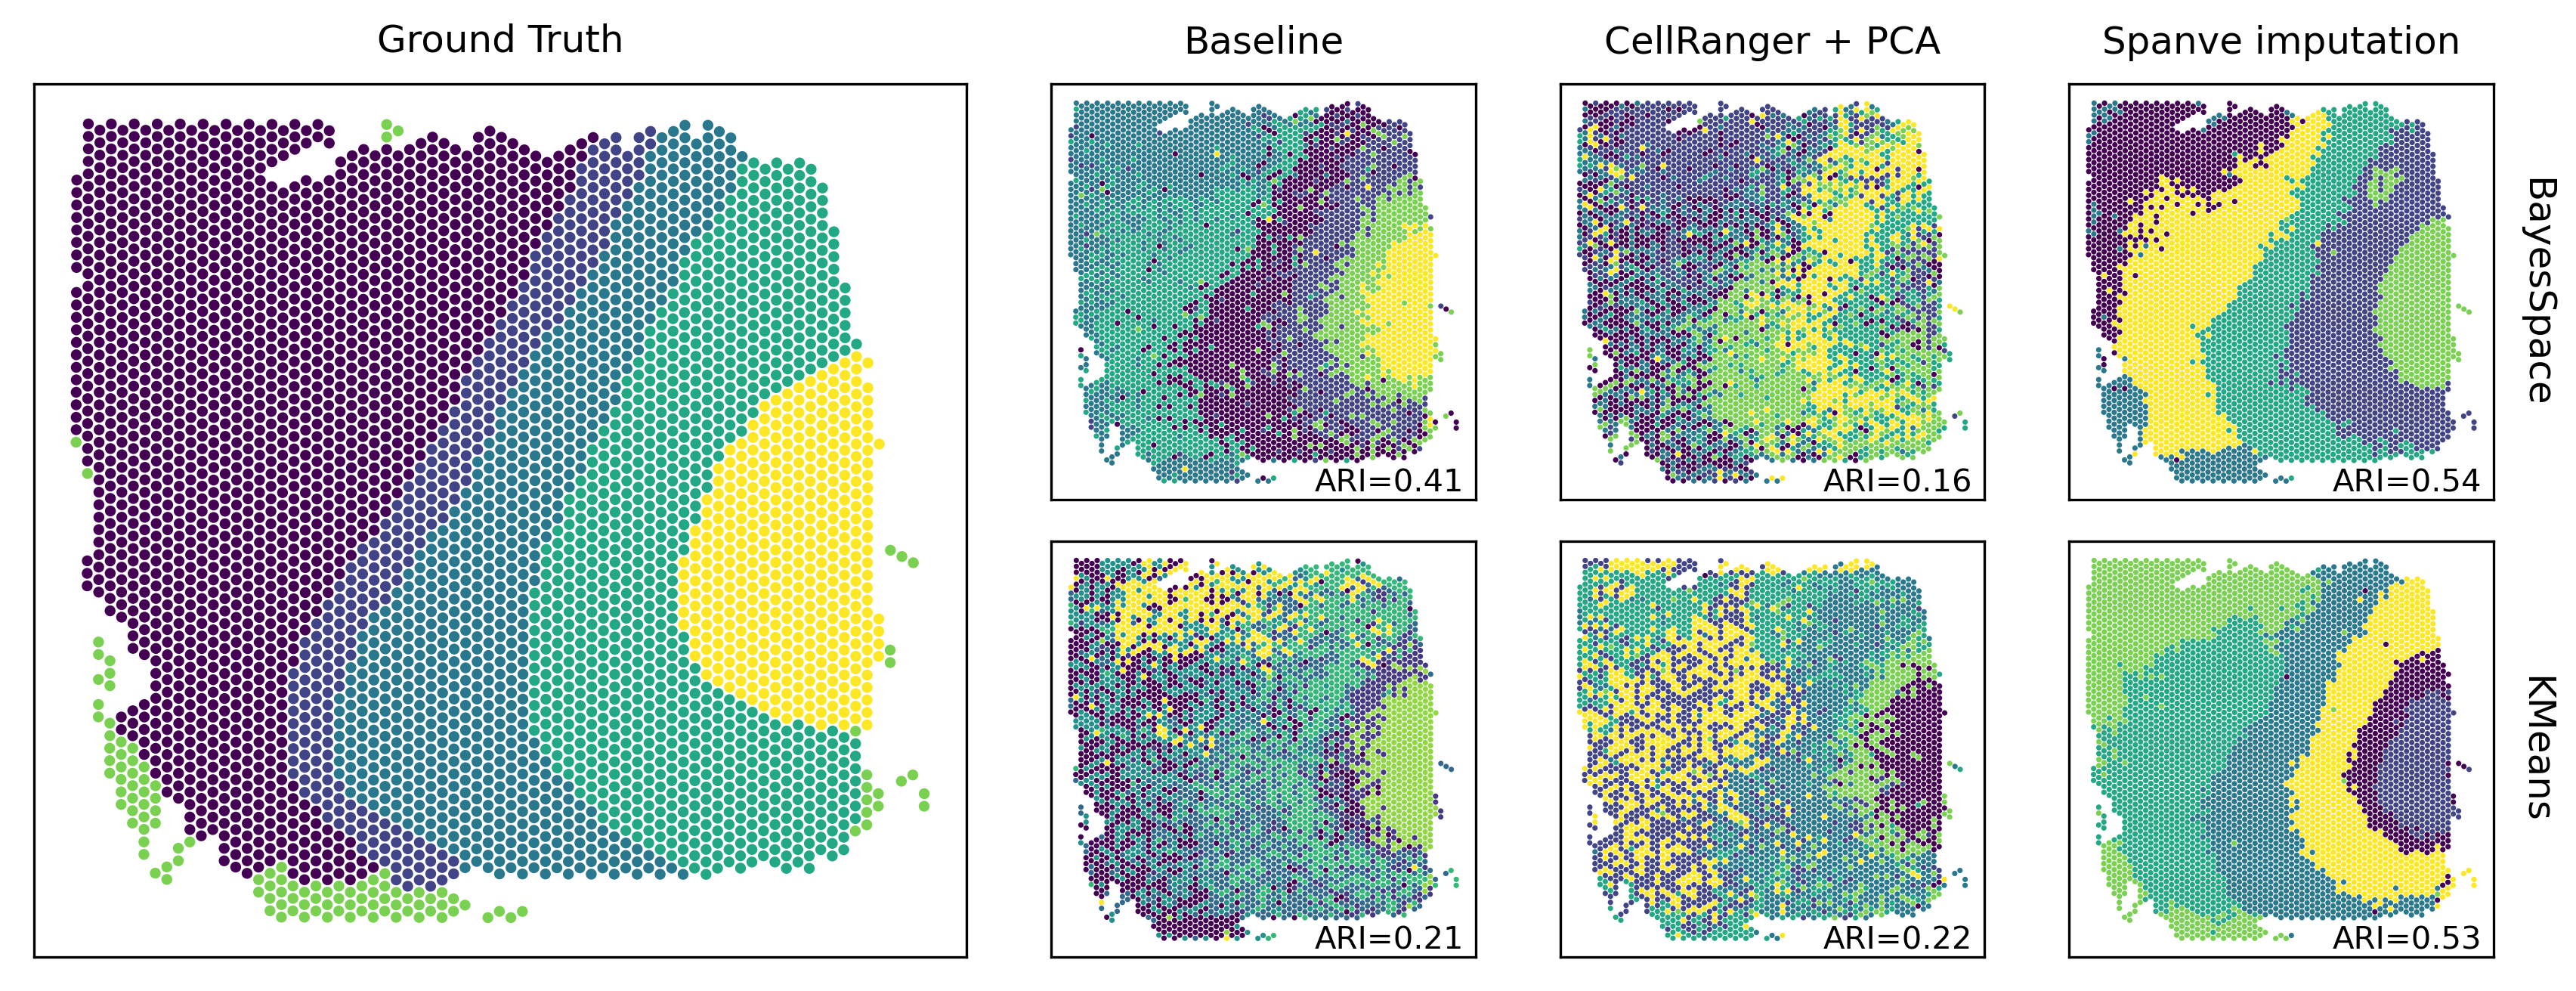

In [13]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np

f = plt.figure(
    dpi=300,
    figsize=(14,5)
)
aspec = f.add_gridspec(
    nrows=2, ncols=5, 
    wspace=0.2, hspace=0.1
)
ax_ground = f.add_subplot(aspec[0:2, 0:2])
ax_BS_base = f.add_subplot(aspec[0, 2])
ax_BS_spi = f.add_subplot(aspec[0, 4])
ax_KM_base = f.add_subplot(aspec[1, 2])
ax_KM_spi = f.add_subplot(aspec[1, 4])
ax_BS_cr = f.add_subplot(aspec[0, 3])
ax_KM_cr = f.add_subplot(aspec[1, 3])

ground = adata.obs['ground_truth']
plot_spatial(ground.values.astype(object),adata,ax=ax_ground,s=6)
for ax,label in zip(
    [ax_KM_spi, ax_KM_cr, ax_KM_base, ax_BS_spi, ax_BS_base, ax_BS_cr],
    label_KM.values.T.tolist() + label_BS.values.T.tolist()
):
    plot_spatial(np.array(label),adata,ax=ax,s=0.5,add_text = f'ARI={ari(ground,label):.2f}')

fontsize = 12
text_obj1 = ax_ground.text(
    s='Ground Truth',x=0.5,y=1.05,
    size=fontsize,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_ground.transAxes,
)
text_obj2 = ax_BS_base.text(
    s='Baseline',x=0.5,y=1.1,
    size=fontsize,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_BS_base.transAxes,
)

text_objcr = ax_BS_cr.text(
    s='CellRanger + PCA',x=0.5,y=1.1,
    size=fontsize,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_BS_cr.transAxes,
)

text_obj3 = ax_BS_spi.text(
    s='Spanve imputation',x=0.5,y=1.1,
    size=fontsize,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_BS_spi.transAxes,
)

text_obj4 = ax_BS_spi.text(
    s='BayesSpace',x=1.1,y=0.5,rotation=-90,
    size=fontsize,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_BS_spi.transAxes,
)

text_obj5 = ax_KM_spi.text(
    s='KMeans',x=1.1,y=0.5,rotation=-90,
    size=fontsize,
    verticalalignment='center', horizontalalignment='center',
    transform=ax_KM_spi.transAxes,
)

In [14]:
f.savefig('./Results/151672_example_impute_clust.pdf',bbox_inches='tight')
f.savefig('./Results/151672_example_impute_clust.tif',bbox_inches='tight', dpi=300)